In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import datetime as dt
import re
from geopy.distance import vincenty
import matplotlib.dates as mdts
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
% matplotlib inline
import cartopy.crs as ccrs
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, make_scorer, roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from time import time
from tsfresh import extract_relevant_features, extract_features
import xgboost as xgb
import warnings
from sklearn.externals import joblib

/opt/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
dataset= pd.read_csv('../data/PeMS/Incidents/work_folder/windows.csv', parse_dates=['Timestamp'])

### Optional: adding weather to dataset

In [ ]:
weather = pd.read_csv('../data/Weather/weather.csv', parse_dates=["Date"])

weather['Date'] = weather.Date.dt.date

dataset['Date'] = dataset.Timestamp.dt.date

dataset = dataset.merge(weather, how='left', on='Date').drop(columns='Date')

### Optional: creation of the set of extracted features

In [ ]:
def feature_extraction(dataset):
    cols = [col for col in dataset.columns if 'Avg' in col or 'Total' in col]
    dataset = dataset[cols]
    t_labels = np.arange(len(cols)/3, dtype=int)
    t_labels = np.concatenate((t_labels,t_labels,t_labels))
    aux_labels = pd.DataFrame({'val_name': cols, 't': t_labels})
    long = dataset.reset_index().melt(id_vars=['index'], var_name='series_param', value_name='value')
    long = long.merge(aux_labels, how='left', left_on='series_param', right_on='val_name').drop('val_name', axis=1)
    long['series_param'] = long['series_param'].apply(lambda row: row.split('_')[0])
    long = long.rename(columns={'index': 'ID'})[['ID', 't', 'series_param', 'value']]
    extracted = extract_features(long, column_id='ID', column_sort='t', column_kind='series_param', column_value='value', n_jobs=4)
    # try imputation
    extracted.dropna(axis=1, how='any', inplace=True)
    return extracted

In [ ]:
def batch_extraction(dataset, b_size):
    m=dataset.shape[0]
    result=pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = feature_extraction(dataset.loc[i:i+b_size-1])
#         result = pd.concat((result, crnt_ftrs))
        crnt_ftrs.to_csv('../data/PeMS/Incidents/work_folder/extracted/extracted_{0:d}.csv'.format(i), index=False)
    print('Extraction complete')


In [ ]:
rnm_cols = ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']

In [ ]:
dct = dict()
for col in rnm_cols:
    dct['Next_'+col] = 'Next '+col

dataset.rename(columns=dct, inplace=True)

In [ ]:
batch_extraction(dataset, 1000)

In [ ]:
def batch_concatenation(dataset, b_size):
    m=dataset.shape[0]
    result = pd.DataFrame()
    for i in range(0, m, b_size):
        crnt_ftrs = pd.read_csv('../data/PeMS/Incidents/work_folder/fst_dataset/extracted/extracted_{0:d}.csv'.format(i))
        crnt_ftrs = crnt_ftrs.replace([np.inf, -np.inf], np.NaN)
        crnt_ftrs.dropna(axis=1, inplace=True)
        result = pd.concat((result, crnt_ftrs), axis=0)
    result = result.dropna(axis=1).reset_index(drop=True)
    non_series_cols = [col for col in dataset.columns if 'Avg' not in col and 'Total' not in col]
    result = pd.concat((result, dataset[non_series_cols]), axis=1)
    return result

In [ ]:
dataset = batch_concatenation(dataset,1000)

In [ ]:
dataset.to_csv('../data/PeMS/Incidents/work_folder/fst_dataset/extracted.csv', index=False)

# Run Logistic Regression and Random Forest

In [3]:
fignum = 1
def score_dataset(dataset, drop_features=[], cv=5):
    global fignum
    drop_cols = ['y', 'Timestamp', 'ID_Prev', 'ID_Next', 'Latitude_Next', 'Longitude_Next', 'Latitude_Prev', 'Longitude_Prev'] + drop_features #, 'Longitude', 'Latitude'
    tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2)
    scaler = StandardScaler()
    tr_X = scaler.fit_transform(tr_X)
    te_X = scaler.transform(te_X)
    print(fignum)    
    print('Logistic regression')
    logreg = LogisticRegression()
    cv_res = cross_validate(logreg, tr_X, tr_y, n_jobs=-1, cv=cv, scoring=['f1', 'roc_auc', 'precision', 'recall'])# scoring={'f1_score' : make_scorer(f1_score)})
    F1_score = cv_res['test_f1'].mean()
    F1_var = cv_res['test_f1'].std()
    RA_score = cv_res['test_roc_auc'].mean()
    RA_var = cv_res['test_roc_auc'].std()
    P_score = cv_res['test_precision'].mean()
    P_var = cv_res['test_precision'].std()
    R_score = cv_res['test_recall'].mean()
    R_var = cv_res['test_recall'].std()
    
    print('{}-fold CV f1 = {}, std = {}'.format(cv, F1_score, F1_var))
    print('{}-fold CV ROC AUC = {}, std = {}'.format(cv, RA_score, RA_var))
    print('{}-fold CV P = {}, std = {}'.format(cv, P_score, P_var))
    print('{}-fold CV R = {}, std = {}'.format(cv, R_score, R_var))
    logreg.fit(tr_X, tr_y)
    predict = logreg.predict(te_X)
    proba = logreg.predict_proba(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    lr_fpr, lr_tpr, thresholds = roc_curve(te_y, proba[:,1])
    plt.plot(lr_fpr, lr_tpr)
    plt.plot([0,1], [0,1])
    plt.grid()
    plt.savefig('../data/PeMS/Incidents/work_folder/figs/log/roc_auc_{}'.format(fignum), lw=4, dpi=600)
    plt.show()
    print()
    
    print('Random Forest')
    forest = RandomForestClassifier(random_state=14)  
    cv_res = cross_validate(forest, tr_X, tr_y, n_jobs=-1, cv=cv, scoring=['f1', 'roc_auc', 'precision', 'recall'])
    F1_score = cv_res['test_f1'].mean()
    F1_var = cv_res['test_f1'].std()
    RA_score = cv_res['test_roc_auc'].mean()
    RA_var = cv_res['test_roc_auc'].std()
    P_score = cv_res['test_precision'].mean()
    P_var = cv_res['test_precision'].std()
    R_score = cv_res['test_recall'].mean()
    R_var = cv_res['test_recall'].std()
    
    print('{}-fold CV f1 = {}, std = {}'.format(cv, F1_score, F1_var))
    print('{}-fold CV ROC AUC = {}, std = {}'.format(cv, RA_score, RA_var))
    print('{}-fold CV P = {}, std = {}'.format(cv, P_score, P_var))
    print('{}-fold CV R = {}, std = {}'.format(cv, R_score, R_var))
    forest.fit(tr_X, tr_y)
    predict = forest.predict(te_X)
    proba = forest.predict_proba(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    fpr, tpr, thresholds = roc_curve(te_y, proba[:,1])
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1])
    plt.grid()
    plt.savefig('../data/PeMS/Incidents/work_folder/figs/rnd/roc_auc_{}'.format(fignum), lw=4, dpi=600)
    plt.show()
    fignum += 1
    print()
    return logreg, lr_fpr, lr_tpr, forest, fpr, tpr


1
Logistic regression
5-fold CV f1 = 0.6271048985968994, std = 0.010102779181779912
5-fold CV ROC AUC = 0.7254300614846874, std = 0.00621586266550119
5-fold CV P = 0.7066101335093463, std = 0.011650284299185498
5-fold CV R = 0.5637063516576943, std = 0.009662229610355403
example CM = [[2674  791]
 [1357 1788]]


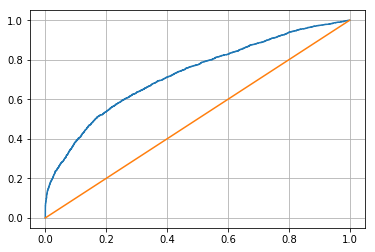


Random Forest
5-fold CV f1 = 0.6548934989944241, std = 0.012001830590999352
5-fold CV ROC AUC = 0.7528718177137083, std = 0.007143823096906338
5-fold CV P = 0.7213578213852554, std = 0.0099946722609855
5-fold CV R = 0.5997926342524253, std = 0.01590951650589152
example CM = [[2698  767]
 [1218 1927]]


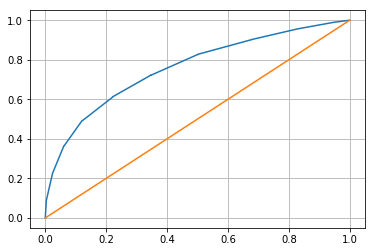

In [4]:
logreg, all_lfpr, all_ltpr, forest, all_lfpr_f, all_ltpr_f = score_dataset(dataset)

### Run without the readings of the downstream sensor

In [ ]:
Next_cols = ['Next Avg Occupancy_0','Next Avg Occupancy_1','Next Avg Occupancy_2',
             'Next Avg Occupancy_3','Next Avg Occupancy_4','Next Avg Occupancy_5',
             'Next Avg Occupancy_6','Next Avg Occupancy_7','Next Avg Occupancy_8',
             'Next Avg Occupancy_9','Next Avg Occupancy_10','Next Avg Occupancy_11',
             'Next Avg Occupancy_12','Next Avg Occupancy_13','Next Avg Occupancy_14',
             'Next Avg Occupancy_15','Next Total Flow_0','Next Total Flow_1',
             'Next Total Flow_2','Next Total Flow_3','Next Total Flow_4',
             'Next Total Flow_5','Next Total Flow_6','Next Total Flow_7',
             'Next Total Flow_8','Next Total Flow_9','Next Total Flow_10',
             'Next Total Flow_11','Next Total Flow_12','Next Total Flow_13',
             'Next Total Flow_14','Next Total Flow_15','Next Avg Speed_0',
             'Next Avg Speed_1','Next Avg Speed_2','Next Avg Speed_3',
             'Next Avg Speed_4','Next Avg Speed_5','Next Avg Speed_6',
             'Next Avg Speed_7','Next Avg Speed_8','Next Avg Speed_9',
             'Next Avg Speed_10','Next Avg Speed_11','Next Avg Speed_12',
             'Next Avg Speed_13','Next Avg Speed_14','Next Avg Speed_15']

score_dataset(dataset, Next_cols)

### Create features: linear and square difference between upstream and downstream sensor readings

In [ ]:
for col in ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']:
    dataset[col] = dataset[col] - dataset['Next '+col]
    dataset[col + '_sq'] = (dataset[col] - dataset['Next '+col] )**2
    dataset.drop(columns='Next '+col, inplace=True)

sq_cols = [col for col in dataset.columns if '_sq' in col]

non_sq_cols = ['Avg Occupancy_0', 'Avg Occupancy_1', 'Avg Occupancy_2',
       'Avg Occupancy_3', 'Avg Occupancy_4', 'Avg Occupancy_5',
       'Avg Occupancy_6', 'Avg Occupancy_7', 'Avg Occupancy_8',
       'Avg Occupancy_9', 'Avg Occupancy_10', 'Avg Occupancy_11',
       'Avg Occupancy_12', 'Avg Occupancy_13', 'Avg Occupancy_14',
       'Avg Occupancy_15', 'Avg Speed_0', 'Avg Speed_1', 'Avg Speed_2',
       'Avg Speed_3', 'Avg Speed_4', 'Avg Speed_5', 'Avg Speed_6',
       'Avg Speed_7', 'Avg Speed_8', 'Avg Speed_9', 'Avg Speed_10',
       'Avg Speed_11', 'Avg Speed_12', 'Avg Speed_13', 'Avg Speed_14',
       'Avg Speed_15', 'Total Flow_0', 'Total Flow_1', 'Total Flow_2',
       'Total Flow_3', 'Total Flow_4', 'Total Flow_5', 'Total Flow_6',
       'Total Flow_7', 'Total Flow_8', 'Total Flow_9', 'Total Flow_10',
       'Total Flow_11', 'Total Flow_12', 'Total Flow_13', 'Total Flow_14',
       'Total Flow_15']

In [ ]:
score_dataset(dataset)

# Classification with XGBoost

In [ ]:
fignum=1
def boost(dataset, drop_features=[], cv=5):
    global fignum
    print(fignum)
    drop_cols = ['y', 'Timestamp', 'ID_Prev', 'ID_Next', 'Latitude_Next', 'Longitude_Next', 'Latitude_Prev', 'Longitude_Prev'] + drop_features #, 'Longitude', 'Latitude', 'IncidentID', 'ID_Prev', 'ID_Next'
    tr_X, te_X, tr_y, te_y = train_test_split(dataset.drop(columns=drop_cols), dataset['y'], stratify=dataset.y, test_size=.2, random_state=442)
    scaler = StandardScaler()
    tr_X = scaler.fit_transform(tr_X)
    te_X = scaler.transform(te_X)
        
    print('XGBoost')
    xgb_params = {'objective':'binary:logistic', 'learning_rate': 1.0, 'n_estimators': 500}
    clf = xgb.XGBClassifier(**xgb_params)
    cv_res = cross_validate(clf, tr_X, tr_y, n_jobs=-1, cv=cv, scoring=['f1', 'roc_auc', 'precision', 'recall']) # scoring={'f1_score' : make_scorer(f1_score)})
    F1_score = cv_res['test_f1'].mean()
    F1_var = cv_res['test_f1'].std()
    RA_score = cv_res['test_roc_auc'].mean()
    RA_var = cv_res['test_roc_auc'].std()
    P_score = cv_res['test_precision'].mean()
    P_var = cv_res['test_precision'].std()
    R_score = cv_res['test_recall'].mean()
    R_var = cv_res['test_recall'].std()
    
    print('{}-fold CV f1 = {}, std = {}'.format(cv, F1_score, F1_var))
    print('{}-fold CV ROC AUC = {}, std = {}'.format(cv, RA_score, RA_var))
    print('{}-fold CV P = {}, std = {}'.format(cv, P_score, P_var))
    print('{}-fold CV R = {}, std = {}'.format(cv, R_score, R_var))
    clf.fit(tr_X, tr_y)
    predict = clf.predict(te_X)
    proba = clf.predict_proba(te_X)
    print('example CM =', confusion_matrix(te_y, predict))
    fpr, tpr, thresholds = roc_curve(te_y, proba[:,1])
    plt.plot(fpr, tpr, label='ROC')
    plt.plot([0,1], [0,1], label='reference', linestyle='--')
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    plt.grid()
    plt.legend()
    plt.savefig('../data/PeMS/Incidents/work_folder/figs/xgb/roc_auc_{}'.format(fignum), lw=4, dpi=600)
    plt.show()
    fignum += 1
    return clf, fpr, tpr

In [ ]:
extr_clf, extr_fpr, extr_tpr = boost(dataset)

# Experiments with window size changing

In [ ]:
def crop_window(dataset, mins):
    min_later = np.array([], dtype=str)
    for cc in dataset.columns:
        if 'Avg' in cc or 'Tot' in cc:
            if int(cc.split('_')[-1])>=8+int(mins/5):
                min_later = np.append(min_later, cc)
    return min_later

In [ ]:
min_later_m10 = crop_window(dataset, -10)

In [ ]:
clf_m10, fpr_m10, tpr_m10 = boost(dataset, [cc for cc in min_later_m10])

# Feature importance analysis

In [ ]:
def col_mapper(col):
    if 'Tot' in col or 'Avg' in col:
        vals = col.split('_')
        nbr = int(vals[-1])*5-40
        return vals[0]+' @'+str(nbr)+'\'' if 'Next' in col else 'Prev '+vals[0]+' @'+str(nbr)+'\''
    else:
        if 'Next' in col:
            parts = col.split('_')
            return 'Next ' + parts[0]
        if 'Prev' in col:
            parts = col.split('_')
            return 'Prev ' + parts[0]
        else:
            return col

In [ ]:
ftr_imp = pd.DataFrame(np.hstack((dataset.drop(columns=['y', 'Timestamp', 'ID_Prev', 'ID_Next'] ).columns[:,np.newaxis],clf40.feature_importances_[:,np.newaxis])), columns=['feature', 'importance'])
ftr_imp['feature']=ftr_imp.feature.apply(col_mapper)

rmapp = {key:col_mapper(key) for key in dataset.columns}

In [ ]:
# plt.figure()
# top = ftr_imp.rename(rmapp).sort_values(by='importance', ascending=False).head(30)
# plt.figure(figsize=[15,10])
ax = ftr_imp.rename(rmapp).sort_values(by='importance', ascending=False).head(30).plot.bar(x='feature', figsize=[15,10], grid=True, fontsize=18)
# plt.bar(x=top['feature'], height=top['importance'])
plt.xlabel('')
# ax.get_figure().savefig('../data/PeMS/Incidents/work_folder/figs/xgb/ftr_imp', lw=4, dpi=600, bbox_inches='tight')
plt.savefig('../data/PeMS/Incidents/work_folder/figs/xgb/ftr_imp', lw=4, dpi=600, bbox_inches='tight')